# Insights into Lending Risks


## Importing necessary libraries


In [1]:

import os
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spacy

In [2]:
# Setting display options for better visibility of data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# consents
# Define categories and their associated keywords
# fmt: off
EMP_CATEGORY_KEYWORDS = {
    "government": [ "us government", "federal government", "state government", "local government", 
                   "us army", "us air force", "us navy", "usmc", "department of defense", "department of homeland security", 
                   "department of veterans affairs", "internal revenue service", "united states air force", "military", "nypd", 
                   "faa", "railroad", "Rail", "Los Angeles County", "Southern California Edison", "FBI", "NASA",
    ],
    "tech": [ "ibm", "microsoft", "cisco systems", "hewlett packard", "intel", "apple", "google", 
                "amazon", "oracle", "vmware", "adobe", "salesforce", "dell", "csc", "adp", "siemens", 
                "fiserv", "saic", "honeywell", "fedex", "ups", "KPMG", "Ernst Young", "Booz Allen Hamilton", 
                "Accenture", "Waste Management", "Bechtel", "URS", "Adecco", "Cargill", "Sodexo", "Compass Group", 
                "HP", "Autozone", "Aerotek", "CenturyLink", "Deloitte", "Jacobs Engineering", "Turner Broadcasting", 
                "Madison Square Garden", "RR Donnelley", "Quest Diagnostics", "Xerox", "Sherwin Williams", "Halliburton", 
                "Staples", "Walt Disney World", "New York Life", "LLP", "Technology Solutions", 'PwC', 'Capgemini',
    ],
    "financial": [ "bank of america", "wells fargo", "jp morgan chase", "citi bank", "chase bank", "morgan stanley", 
                  "merrill lynch", "fidelity investments", "bny mellon", "edward jones", "hsbc", "charles schwab", 
                  "Goldman Sachs", "Thomson Reuters", "The Hartford", "Progressive Insurance", "Travelers Insurance", 
                  "Credit Suisse", "TIAA CREF", "Capital One", "GEICO", "Barclays Capital", "Northwestern Mutual", "BBT", 
                  "UBS", "Prudential", "Fannie Mae",
    ],
    "retail": [ "walmart", "target", "sears", "aramark", "best buy", "home depot", "lowes", "walgreens", 
               "macys", "costco", "whole foods market", "gap", "conocophillips", "johnson johnson", "general electric", 
               "Nordstrom", "Frito Lay", "Rite Aid", "Starbucks", "Trader Joes", "Trader Joes", "Kroger", "Staples",
    ],
    "healthcare": [ "kaiser permanente", "cvs pharmacy", "pfizer", "upmc", "AIG", "Cardinal Health", "MetLife", "Cardinal Health", 
                   "MetLife", "Memorial Sloan-Kettering Cancer Center", "Mayo Clinic", "Aetna", "Quest Diagnostics", "Hospital" ],
    "telecom": [ "verizon", "at", "mobile", "sprint", "time warner cable", "verizon wireless", "Comcast", "Century Link",],
    "aerospace": ["boeing", "lockheed martin", "northrop grumman", "raytheon", "bae systems"],
    "university": ["columbia university", "student", "School", "UCLA", "College"],
    "self employed": ["self", "self-employed", "self employed"],
    "unemployed": ["retired", "unemployed"],
}
# fmt: on

EMP_TITLE_CATEGORY = dict()

NLP_lg = None
try:
    NLP_lg = spacy.load("en_core_web_sm")
except OSError:
    import spacy.cli

    spacy.cli.download("en_core_web_sm")
    NLP_lg = spacy.load("en_core_web_sm")

## 🥤Methods

### Data Visualization methods

In [45]:

def visualize_countplot_minimal(df: pd.DataFrame, categorical_col: str) -> None:
    """
        Visualizes the distribution of a categorical column with minimal colors and value labels.
    """
    # Ensure order is a list of category labels
    order = sorted(df[categorical_col].unique())
    
    # Visualize the distribution using a bar plot with minimal colors
    plt.figure(figsize=(10, 6))
    counts = df[categorical_col].value_counts().sort_index()  # Get category counts
    sns.countplot(
        x=categorical_col,
        data=df,
        hue=categorical_col,
        palette="Set2",
        order= order,
        legend=False
    )
    
    # Add value labels on top of each bar
    for i, (_, count) in enumerate(counts.items()):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12)
    
    plt.title(f"Distribution of {categorical_col.replace('_', ' ').capitalize()}")
    plt.xlabel(categorical_col.replace('_', ' ').capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Customize grid and labels for a cleaner look
    plt.tight_layout()  # Adjust spacing for better readability

    plt.show()
    
def visualize_histplot_minimal(df: pd.DataFrame, num_col: str, kde = True, bin = 30) -> None:
    """
        Visualizes the distribution of a numerical column with minimal colors and value labels.
    """
    # Visualize distributions (Example: Loan amount)
    plt.figure(figsize=(10, 6))
    sns.histplot(df[num_col], kde = kde, bins = bin, color='blue')
    plt.title(f"{num_col.replace('_',  ' ').capitalize()} Distribution")
    plt.xlabel(num_col.replace('_',  ' ').capitalize())
    plt.ylabel('Frequency')
    plt.show()

### Data Processing Methods

In [5]:

def correct_year(date_str: str) -> str:
    """Function to correct the year 
    """
    month = date_str[:-2]
    year = int(date_str[-2:])
    
    if year > 11: # As our dataset data is between 2007 to 2011 hance condition is > 11
        return month + "19{:02}".format(year)
    
    return month + "20{:02}".format(year)

def categorize_emp_length(emp_length: str) -> str:
    """
    Categorizes employment length into specific bins.
    """
    emp_length = emp_length.lower().strip()
    if emp_length == 'missing': 
        return 'missing'
    
    if emp_length in ["< 1 year", "1 year", "2 years", "3 years", "4 years"]:
        return "<= 4 year"

    if emp_length in [ "5 years", "6 years", "7 years", "8 years", "9 years"]:
        return "<= 9 years"

    if emp_length == "10+ years":
        return ">= 10 years"

    return "unknown"


def categorize_employer(employer_title: str) -> str:
    """
    Categorizes an employer title into predefined categories.
    """
    if employer_title in EMP_TITLE_CATEGORY:
        return EMP_TITLE_CATEGORY[employer_title]
    # Processes text by removing non-alphanumeric characters and converting to lowercase.
    clean_text = lambda text: (
        re.sub(r"\W+", "", text.lower().strip()) if re.sub(r"\W+", "", text.lower().strip()) != "" else text
    )

    # Preprocess the input employer title
    employer_title_cleaned = clean_text(employer_title)

    if employer_title_cleaned in EMP_TITLE_CATEGORY:
        return EMP_TITLE_CATEGORY[employer_title_cleaned]

    # Categorize the employer
    for category, keywords in EMP_CATEGORY_KEYWORDS.items():
        cleaned_category = clean_text(category)
        for keyword in keywords:
            if employer_title_cleaned in clean_text(keyword):
                EMP_TITLE_CATEGORY[employer_title] = category
                EMP_TITLE_CATEGORY[employer_title_cleaned] = category
                return category
            for word in keyword.split():
                if clean_text(word) in employer_title_cleaned:
                    EMP_TITLE_CATEGORY[employer_title] = category
                    EMP_TITLE_CATEGORY[word] = category
                    return category
        if cleaned_category in employer_title_cleaned:
            return category
    
    try:
        for ent in NLP_lg(employer_title).ents:
            if ent.label_ == "MONEY":
                EMP_TITLE_CATEGORY[employer_title] = "financial"
                return "financial"
            if ent.label_ == "ORG":
                EMP_TITLE_CATEGORY[employer_title] = "company"
                return "tech"
            if ent.label_ == "GPE":
                EMP_TITLE_CATEGORY[employer_title] = "government"
                return "government"
    except:
        pass
    return "unknown"

### Calculation methods:

In [6]:
def get_outlier_count(df: pd.DataFrame, col_name: str) -> None:
    """Calculates and prints the number of outliers in a specified column using the IQR method.
    """
    # IQR method example
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Outliers in {col_name}:", df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)].shape[0])

## ⚙Loading datasets


In [7]:
# Replace 'path_to_file' with the actual path to the files
current_dir = %pwd # type: ignore
data_dir = os.path.join(current_dir, '..', 'data', 'raw')
loan_data_path = os.path.join(data_dir, 'loan.csv')

In [8]:
# Loading loan data
try:
    loan_df_raw: pd.DataFrame = pd.read_csv(loan_data_path, low_memory=False, sep=',')
    print(f"Loan data loaded successfully. Shape: {loan_df_raw.shape}")
except FileNotFoundError:
    print("Error: loan.csv file not found. Please check the file path.")

Loan data loaded successfully. Shape: (39717, 111)


In [9]:
# Displaying first few rows of the dataset
print("\nFirst 5 rows of the loan data:")
display(loan_df_raw.head())


First 5 rows of the loan data:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# Displaying column information
print("\nDataset Information:")
loan_df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [11]:
# Displaying descriptive statistics for numeric columns
print("\nDescriptive Statistics for Numeric Columns:")
display(loan_df_raw.describe())


Descriptive Statistics for Numeric Columns:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,14035.00,2786.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39661.00,0.00,39717.00,0.00,0.00,0.00,39717.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39661.00,39717.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39020.00,39678.00,0.00,0.00,0.00,0.00
mean,683131.91,850463.56,11219.44,10947.71,10397.45,324.56,68968.93,13.32,0.15,0.87,35.90,69.70,9.29,0.06,13382.53,22.09,51.23,50.99,12153.60,11567.15,9793.35,2263.66,1.36,95.22,12.41,2678.83,0.00,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.00,NaN,NaN,NaN,NaN
std,210694.13,265678.31,7456.67,7187.24,7128.45,208.87,63793.77,6.68,0.49,1.07,22.02,43.82,4.40,0.24,15885.02,11.40,375.17,373.82,9042.04,8942.67,7065.52,2608.11,7.29,688.74,148.67,4447.14,0.00,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,0.00,NaN,NaN,NaN,NaN
min,54734.00,70699.00,500.00,500.00,0.00,15.69,4000.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
25%,516221.00,666780.00,5500.00,5400.00,5000.00,167.02,40404.00,8.17,0.00,0.00,18.00,22.00,6.00,0.00,3703.00,13.00,0.00,0.00,5576.93,5112.31,4600.00,662.18,0.00,0.00,0.00,218.68,0.00,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
50%,665665.00,850812.00,10000.00,9600.00,8975.00,280.22,59000.00,13.40,0.00,1.00,34.00,90.00,9.00,0.00,8850.00,20.00,0.00,0.00,9899.64,9287.15,8000.00,1348.91,0.00,0.00,0.00,546.14,0.00,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0

In [12]:
# Checking for missing values
print("\nMissing Values in Each Column:")
missing_values = loan_df_raw.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])  # Display only columns with missing values


Missing Values in Each Column:
num_il_tl                         39717
num_bc_sats                       39717
num_bc_tl                         39717
num_actv_bc_tl                    39717
num_accts_ever_120_pd             39717
mths_since_recent_revol_delinq    39717
num_actv_rev_tl                   39717
mths_since_recent_inq             39717
num_tl_90g_dpd_24m                39717
num_tl_30dpd                      39717
num_tl_120dpd_2m                  39717
num_sats                          39717
num_rev_tl_bal_gt_0               39717
num_rev_accts                     39717
pct_tl_nvr_dlq                    39717
mo_sin_old_il_acct                39717
mo_sin_old_rev_tl_op              39717
mo_sin_rcnt_rev_tl_op             39717
mo_sin_rcnt_tl                    39717
mths_since_recent_bc              39717
mort_acc                          39717
mths_since_recent_bc_dlq          39717
bc_util                           39717
total_rev_hi_lim                  39717
all_util

In [13]:
# Checking for duplicate rows
duplicates = loan_df_raw.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


### 📈 Data Understanding

**Dataset Overview:**

`loan.csv` dataset is a comprehensive record of 39,717 loans. It consists of 111 columns, primarily numeric (74 float64, 13 int64) with a smaller portion of categorical data (24 object).

**Key Observations:**

1. **Unique Identifiers: 💡**

   - `id` and `member_id`, these columns seem to be unique identifiers.

2. **Loan Amount and Funding: 💰**

   - Principal loan amount (`loan_amnt`) ranges from $500(min) to $35,000(max), with an average $11,219.
   - Funded amounts (`funded_amnt` and `funded_amnt_inv`) closely mirror loan amount, indicating successful funding.

3. **Installment Payments: 📆**

   - Monthly payment amount (`installment`) ranges from $15.69(min) to $1,305.19(max), with an average $324.56.

4. **Income and Debt:**

   - Annual income (`annual_inc`) averages around $68,968. However, presence of outliers, such as a max value is of $6 million, suggests potential data entry errors or exceptional cases.
   - Debt-to-income ratio (`dti`) averages 13.32%, with max of 29.99%, which is reasonable for lending. (IMP) [Higher DTI Higher risk to Bank]

5. **Credit History: 💳**

   - Average number of _Open credit accounts_ (`open_acc`) is 9.29.
   - Average number of _Total credit accounts_ (`total_acc`) is 22.09.
   - Average revolving balance (`revol_bal`) is $13,382, with a max of $149,588.

6. **Payment and Recovery: 💵**

   - Total payment amount (`total_pymnt`) averages around $12,153, slightly exceeding average loan amount.
   - Recovery amount (`recoveries`) averages around $95.22, reflecting funds recovered from defaulted loans.

7. **Missing Data: ⚠️**
   - Several columns, such as `mths_since_last_delinq`, `mths_since_last_record`, and `annual_inc_joint`, have significant missing data, indicating potential data collection limitations.

   **Data Quality Concerns/ observations:**

   - Outliers exist in columns like `annual_inc` and `revol_bal`.
   - Columns like `policy_code` contain mostly a 1-2/single value or NaN, offering min variance.
   - Columns like `zip_code` is having incomplete data we will continue with `addr_state`
   - Columns like `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `tax_liens`, `acc_now_delinq`, `delinq_amnt` has value 1/single value (predominately 0) or NaN, invalid or error-pron data.


## 🧹 Data Cleaning and Manipulation

### 🔍Handle missing values

In [14]:
# Check for missing values
# Set a threshold for significant missing values
missing_value_threshold = 90 # After experimenting with multiple values concluded to look for more then 90%

# Calculate missing values as a percentage
missing_values_percentage = loan_df_raw.isnull().sum() * 100 / len(loan_df_raw)

# Filter columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_values_percentage[missing_values_percentage > missing_value_threshold]

# Print the results in a clear and concise format
print("Columns with missing values exceeding the threshold of {}%:\n".format(missing_value_threshold))
display(columns_with_high_missing_values)

Columns with missing values exceeding the threshold of 90%:



mths_since_last_record            92.99
next_pymnt_d                      97.13
mths_since_last_major_derog      100.00
annual_inc_joint                 100.00
dti_joint                        100.00
verification_status_joint        100.00
tot_coll_amt                     100.00
tot_cur_bal                      100.00
open_acc_6m                      100.00
open_il_6m                       100.00
open_il_12m                      100.00
open_il_24m                      100.00
mths_since_rcnt_il               100.00
total_bal_il                     100.00
il_util                          100.00
open_rv_12m                      100.00
open_rv_24m                      100.00
max_bal_bc                       100.00
all_util                         100.00
total_rev_hi_lim                 100.00
inq_fi                           100.00
total_cu_tl                      100.00
inq_last_12m                     100.00
acc_open_past_24mths             100.00
avg_cur_bal                      100.00


In [15]:

# Drop unnecessary columns

# Let's get rid of those columns that don't tell us anything interesting 🗑️.
columns_to_drop = ['id', 'member_id', # dropping user identifier as they are note relevant for analysis 
                   'url', 'desc', # Static text data
                   'zip_code', # zip code has issue where it's not complete we will continue with `addr_state`
                   'policy_code', # As per understanding of business and data dropping
                   'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'acc_now_delinq', 'delinq_amnt']
loan_clean_df = loan_df_raw.drop(columns=columns_to_drop)

# After experimenting with multiple values concluded to look for more then 90%
# Set a threshold for dropping columns with high missing values (90% in this case)
# Calculate the minimum number of non-missing values required per column
min_non_missing_values = int(0.9 * len(loan_clean_df))

# Drop columns with more missing values than the threshold
loan_clean_df.dropna(thresh=min_non_missing_values, axis=1, inplace=True)

In [16]:
loan_clean_df.shape

(39717, 43)

### 🔢Numerical Data

In [17]:

# Convert data types
loan_clean_df['term'] = loan_clean_df['term'].str.extract('(\d+)').astype(int)  # Extract numeric values from strings

# Convert relevant columns to float format
float_columns = ['int_rate', 'revol_util']
for col in float_columns:
    loan_clean_df[col] = loan_clean_df[col].str.replace('%', '').astype(float)

# Impute remaining missing values
loan_clean_df['annual_inc'] = loan_clean_df['annual_inc'].fillna(loan_clean_df['annual_inc'].median())  # Median for numerical column
loan_clean_df['revol_util'] = loan_clean_df['revol_util'].fillna(loan_clean_df['revol_util'].median())  # Median imputation for numeric

loan_clean_df['pub_rec_bankruptcies'] = loan_clean_df['pub_rec_bankruptcies'].fillna(0)  # Treat missing as 0


### 📆Datetime Data

In [18]:
# filling missing data form date columns with current month and year
loan_clean_df['last_pymnt_d'] = loan_clean_df['last_pymnt_d'].fillna('Dec-11') # Data imputed as 'Dec-11'
loan_clean_df['last_credit_pull_d'] = loan_clean_df['last_credit_pull_d'].fillna('Dec-11') # Data imputed as 'Dec-11'

date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    loan_clean_df[col] = pd.to_datetime(loan_clean_df[col].apply(lambda date_str: correct_year(date_str)), format='%b-%Y', errors='coerce')

In [19]:
# Basic descriptive statistics for datetime columns
print("\nDescriptive Statistics: (Datetime columns)")
loan_clean_df[date_columns].describe()



Descriptive Statistics: (Datetime columns)


,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
count,39717,39717,39717,39717
mean,2010-11-03 23:26:45.166553344,1997-01-18 21:45:07.545887104,1932-06-07 15:47:53.419442432,1923-02-09 20:07:31.393609984
min,2007-06-01 00:00:00,1946-01-01 00:00:00,1912-01-01 00:00:00,1912-01-01 00:00:00
25%,2010-05-01 00:00:00,1993-11-01 00:00:00,1913-02-01 00:00:00,1914-02-01 00:00:00
50%,2011-02-01 00:00:00,1998-05-01 00:00:00,1914-02-01 00:00:00,1915-11-01 00:00:00
75%,2011-08-01 00:00:00,2001-09-01 00:00:00,1915-11-01 00:00:00,1916-05-01 00:00:00
max,2011-12-01 00:00:00,2008-11-01 00:00:00,2011-12-01 00:00:00,2011-12-01 00:00:00


### 🗃Categorical Data

In [20]:
# Count the occurrences of different loan terms
print("Distribution of Loan Terms:")
print(loan_clean_df['term'].value_counts())

Distribution of Loan Terms:
term
36    29096
60    10621
Name: count, dtype: int64


In [21]:
# Impute remaining missing values
loan_clean_df['title'] = loan_clean_df['title'].fillna(loan_clean_df['title'].mode()[0])  # Fill with mode
loan_clean_df['emp_title'] = loan_clean_df['emp_title'].fillna('Unknown')  # Categorical imputation
loan_clean_df['emp_length'] = loan_clean_df['emp_length'].fillna('missing')  # Fill with default category

In [22]:
# Verify remaining missing values
print("\nRemaining Missing Values:")
print(loan_clean_df.isnull().sum())


Remaining Missing Values:
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
pymnt_plan                 0
purpose                    0
title                      0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp 

In [23]:
# Displaying first few rows of the dataset
print("\nFirst 5 rows of the loan data: (After processing)")
loan_clean_df.head()


First 5 rows of the loan data: (After processing)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,pub_rec_bankruptcies
0,5000,5000,4975.00,36,10.65,162.87,B,B2,Unknown,10+ years,RENT,24000.00,Verified,2011-12-01,Fully Paid,n,credit_card,Computer,AZ,27.65,0,1985-01-01,1,3,0,13648,83.70,9,f,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,1915-01-01,171.62,1916-05-01,INDIVIDUAL,0.00
1,2500,2500,2500.00,60,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,2011-12-01,Charged Off,n,car,bike,GA,1.00,0,1999-04-01,5,3,0,1687,9.40,4,f,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,1913-04-01,119.66,1913-09-01,INDIVIDUAL,0.00
2,2400,2400,2400.00,36,15.96,84.33,C,C5,Unknown,10+ years,RENT,12252.00,Not Verified,2011-12-01,Fully Paid,n,small_business,real estate business,IL,8.72,0,2001-11-01,2,2,0,2956,98.50,10,f,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,1914-06-01,649.91,1916-05-01,INDIVIDUAL,0.00
3,10000,10000,10000.00,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,2011-12-01,Fully Paid,n,other,personel,CA,20.00,0,1996-02-01,1,10,0,5598,21.00,37,f,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,1915-01-01,357.48,1916-04-01,INDIVIDUAL,0.00
4,3000,3000,3000.00,60,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,2011-12-01,Current,n,other,Personal,OR,17.94,0,1996-01-01,0,15,0,27783,53.90,38,f,524.06,524.06,3513.33,3513.33,2475.94,1037.39,0.00,0.00,0.00,1916-05-01,67.79,1916-05-01,INDIVIDUAL,0.00


In [24]:
categorical_cols = loan_clean_df.select_dtypes(include=['object']).columns.tolist()
print("\nFirst 5 rows of the loan data: (After processing)[only object type]")
loan_clean_df[categorical_cols].head()


First 5 rows of the loan data: (After processing)[only object type]


,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,initial_list_status,application_type
0,B,B2,Unknown,10+ years,RENT,Verified,Fully Paid,n,credit_card,Computer,AZ,f,INDIVIDUAL
1,C,C4,Ryder,< 1 year,RENT,Source Verified,Charged Off,n,car,bike,GA,f,INDIVIDUAL
2,C,C5,Unknown,10+ years,RENT,Not Verified,Fully Paid,n,small_business,real estate business,IL,f,INDIVIDUAL
3,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Fully Paid,n,other,personel,CA,f,INDIVIDUAL
4,B,B5,University Medical Group,1 year,RENT,Source Verified,Current,n,other,Personal,OR,f,INDIVIDUAL


In [25]:
# Analyze categorical variables with minimal color scheme
for categorical_col in categorical_cols:
    print(f"Column: {categorical_col}")
    print(loan_clean_df[categorical_col].value_counts())
    print()
    

Column: grade
grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64

Column: sub_grade
sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64

Column: emp_title
emp_title
Unknown                     2459
US Army                      134
Bank of America              109
IBM                           66
AT&T                          59
                            ... 
Stratagem, Inc.                1
Panavision International       1
Duracell                       1
Chin's Restaurant              1
Internal revenue Service       1
Name: count, Length: 28821, dtype: int64

Col

##### 👀Observations:
- The columns `application_type`, `initial_list_status`, and `pymnt_plan` seem to have limited variability, making them potentially redundant.
- The `title` column, with its high number of unique values, might not be very informative. The `purpose` column could be a more useful alternative.
- The `emp_length` column can be simplified by grouping similar values into broader categories.
- The `emp_title` column has too many unique values to be directly useful. Text-based categorization techniques can be employed to group similar titles into meaningful categories.
- The 'NONE' value in the `home_ownership` column requires attention. It might be appropriate to replace it with 'OTHER'.

##### 📌Next Steps:
- Remove `application_type`, `initial_list_status`, and `pymnt_plan`.
- Use the `purpose` column instead of `title` for analysis.
- Group `emp_length` into categories like '<= 1 year', '1-5 years', '6-9 years', and '10+ years'.
- Use prep dict manually and with GPT and Gemini model to categorize `emp_title` into broader categories such as 'Government', 'Tech', 'Finance', 'Healthcare', etc.
- Address missing values in the `home_ownership` column by replacing 'NONE' with 'OTHER'.

In [26]:
# Dropping the unnecessary columns
columns_to_drop = columns_to_drop + ['application_type', 'initial_list_status', 'pymnt_plan', 'title'] # Newly added columns don't have any variability.
loan_clean_df = loan_clean_df.drop(columns=filter(lambda col: col in loan_clean_df.columns, columns_to_drop))

# Making the data more consistent and potentially more informative for analysis
loan_clean_df.loc[loan_clean_df['home_ownership'] == 'NONE', 'home_ownership'] = 'OTHER'

In [27]:
# Basic descriptive statistics for numeric columns
print("\nDescriptive Statistics:")
display(loan_clean_df.describe())


Descriptive Statistics:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717,39717.00,39717.00,39717,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717,39717.00,39717,39717.00
mean,11219.44,10947.71,10397.45,42.42,12.02,324.56,68968.93,2010-11-03 23:26:45.166553344,13.32,0.15,1997-01-18 21:45:07.545887104,0.87,9.29,0.06,13382.53,48.83,22.09,51.23,50.99,12153.60,11567.15,9793.35,2263.66,1.36,95.22,12.41,1932-06-07 15:47:53.419442432,2678.83,1923-02-09 20:07:31.393609984,0.04
min,500.00,500.00,0.00,36.00,5.42,15.69,4000.00,2007-06-01 00:00:00,0.00,0.00,1946-01-01 00:00:00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1912-01-01 00:00:00,0.00,1912-01-01 00:00:00,0.00
25%,5500.00,5400.00,5000.00,36.00,9.25,167.02,40404.00,2010-05-01 00:00:00,8.17,0.00,1993-11-01 00:00:00,0.00,6.00,0.00,3703.00,25.50,13.00,0.00,0.00,5576.93,5112.31,4600.00,662.18,0.00,0.00,0.00,1913-02-01 00:00:00,218.68,1914-02-01 00:00:00,0.00
50%,10000.00,9600.00,8975.00,36.00,11.86,280.22,59000.00,2011-02-01 00:00:00,13.40,0.00,1998-05-01 00:00:00,1.00,9.00,0.00,8850.00,49.30,20.00,0.00,0.00,9899.64,9287.15,8000.00,1348.91,0.00,0.00,0.00,1914-02-01 00:00:00,546.14,1915-11-01 00:00:00,0.00
75%,15000.00,15000.00,14400.00,60.00,14.59,430.78,82300.00,2011-08-01 00:00:00,18.60,0.00,2001-09-01 00:00:00,1.00,12.00,0.00,17058.00,72.30,29.00,0.00,0.00,16534.43,15798.81,13653.26,2833.40,0.00,0.00,0.00,1915-11-01 00:00:00,3293.16,1916-05-01 00:00:00,0.00
max,35000.00,35000.00,35000.00,60.00,24.59,1305.19,6000000.00,2011-12-01 00:00:00,29.99,11.00,2008-11-01 00:00:00,8.00,44.00,4.00,149588.00,99.90,90.00,6311.47,6307.37,58563.68,58563.68,35000.02,23563.68,180.20,29623.35,7002.19,2011-12-01 00:00:00,36115.20,2011-12-01 00:00:00,2.00
std,7456.67,7187.24,7128.45,10.62,3.72,208.87,63793.77,NaN,6.68,0.49,NaN,1.07,4.40,0.24,15885.02,28.31,11.40,375.17,373.82,9042.04,8942.67,7065.52,2608.11,7.29,688.74,148.67,NaN,4447.14,NaN,0.20


### 🛠Derived Features

#### 🔑Key Points:
__DATASET IMPORTANT FEATURES by multiple articles of loan eligibility__

1. Debt to income ratio (`dti`) 
2. Employee Work Experience (`emp_length`)
3. Loan Amount (`loan_amnt`)
4. Annual Income (`annual_inc`)
5. Loan Amount (`loan_amnt`)
   
__NEED TO CALCULATE IMPORTANT FEATURES by multiple articles of loan eligibility__
1. Loan to income ratio (`LTI`)
   * LTI = Total Loan Amount / Annual Income
2. Credit age (`credit_age`) 
   * Credit age = Today Date Day(int) - Earlist Credit Date Day(int) / 365
3. Risk Score (`risk_score`)
   * Risk Score = RANK of( DTI * Interest Rate / Credit Age)

**References:** <br>
- <a hrf=https://fastercapital.com/content/Loan-to-income-ratio--Understanding-Loan-to-Income-Ratio--A-Guide-for-Entrepreneurs.html>Article 1</a><br>
- <a hrf=https://www.bajajfinserv.in/personal-loan-eligibility-calculator>Article 2</a>

#### Numerical data:

In [28]:
# Calculate the Loan-to-Income Ratio (LTI)
loan_clean_df['lti'] = loan_clean_df['loan_amnt'] / loan_clean_df['annual_inc'] 
# Measures borrower's debt burden relative to their income.
# A higher LTI indicates a higher risk of default, as borrower may struggle to meet their monthly payments.



# Calculate the time since the earliest credit line (in years)
loan_clean_df['credit_age'] = (pd.to_datetime('today') - loan_clean_df['earliest_cr_line']).dt.days / 365 
# Represents number of years since borrower's earliest credit line was opened.
# A longer credit history generally indicates a more stable financial history and lower risk.


# Build Risk Score Value using data understanding:
loan_clean_df['risk_score'] = (loan_clean_df['dti']  / (loan_clean_df['int_rate'] * loan_clean_df['credit_age'])).rank()


# Print summary statistics of the newly created features
print("Summary Statistics of Key Features:")
display(loan_clean_df[['dti', 'int_rate', 'loan_amnt', 'annual_inc', 'lti', 'credit_age', 'int_rate', 'loan_amnt', 'risk_score']].describe())


Summary Statistics of Key Features:


,dti,int_rate,loan_amnt,annual_inc,lti,credit_age,int_rate,loan_amnt,risk_score
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00
mean,13.32,12.02,11219.44,68968.93,0.19,27.86,12.02,11219.44,19859.00
std,6.68,3.72,7456.67,63793.77,0.12,6.84,3.72,7456.67,11465.45
min,0.00,5.42,500.00,4000.00,0.00,16.06,5.42,500.00,92.00
25%,8.17,9.25,5500.00,40404.00,0.10,23.24,9.25,5500.00,9930.00
50%,13.40,11.86,10000.00,59000.00,0.17,26.58,11.86,10000.00,19859.00
75%,18.60,14.59,15000.00,82300.00,0.25,31.07,14.59,15000.00,29788.00
max,29.99,24.59,35000.00,6000000.00,0.83,78.94,24.59,35000.00,39717.00


#### Categorical Data:

In [30]:
# Categorize employment length into more meaningful categories
loan_clean_df['emp_yoe'] =  loan_clean_df['emp_length'].apply(categorize_emp_length)

# Validating of any other new category
print("\nDistribution of Employment Experience category:")
print(loan_clean_df['emp_yoe'].value_counts())

# Categorize the employer titles into meaningful categories
loan_clean_df['emp_prof_name'] = loan_clean_df['emp_title'].apply(categorize_employer)

# Print the distribution of categories
print("\nDistribution of Employment Categories:")
print(loan_clean_df['emp_prof_name'].value_counts())


Distribution of Employment Experience category:
emp_yoe
<= 4 year      19742
<= 9 years     10021
>= 10 years     8879
missing         1075
Name: count, dtype: int64

Distribution of Employment Categories:
emp_prof_name
tech             10141
government       10052
unknown           8268
financial         3056
telecom           2852
healthcare        1827
retail            1529
university         949
company            653
self employed      181
aerospace          170
unemployed          39
Name: count, dtype: int64


### ❕Handle Outliers

Outliers in loan_amnt: 1230


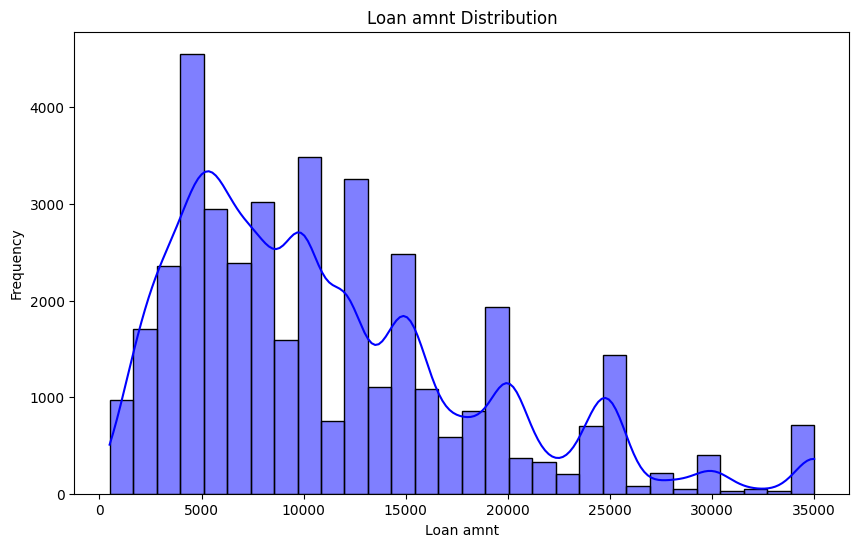

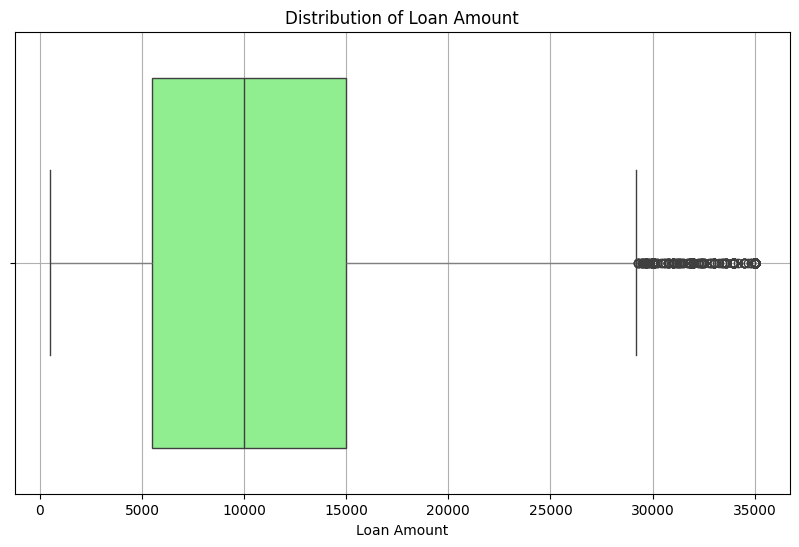

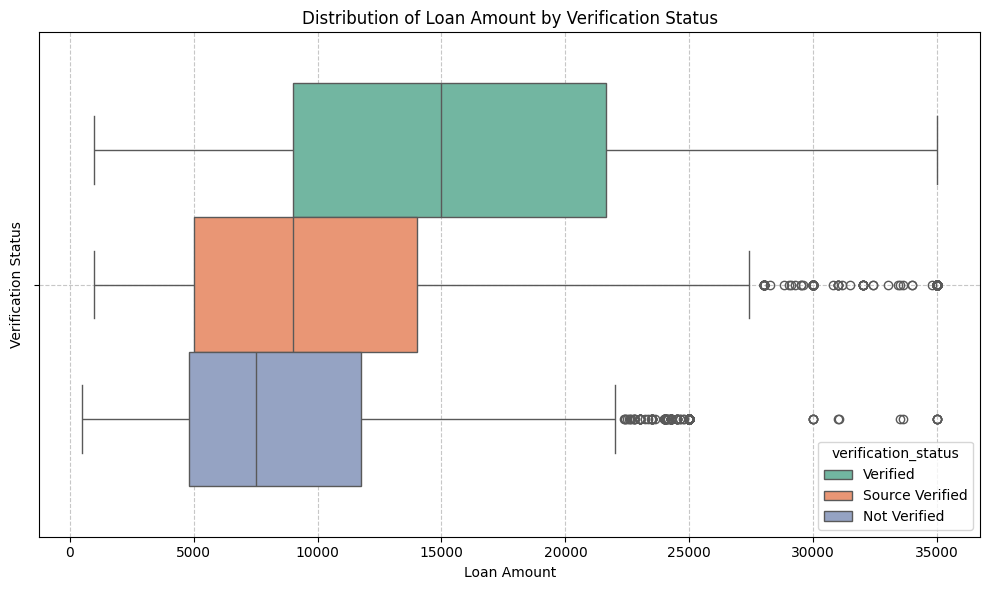

In [31]:
get_outlier_count(loan_clean_df, 'loan_amnt') 

visualize_histplot_minimal(loan_clean_df, 'loan_amnt')

# Create a box plot with a minimal style
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_amnt', data=loan_clean_df, whis=1.5, boxprops={'facecolor': 'lightgreen'}, whiskerprops={'color': 'gray'})
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.grid(True)
plt.show()

# Create a box plot with a minimal style
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="loan_amnt",  
    data=loan_clean_df,
    hue="verification_status",  
    palette="Set2"
)
plt.title("Distribution of Loan Amount by Verification Status")
plt.xlabel("Loan Amount")
plt.ylabel("Verification Status")
plt.grid(True, linestyle="--", alpha=0.7)  # Adjust grid for better readability
plt.tight_layout()
plt.show()

#### 📍Key Observations:
- Median Loan Amount:
  - `Verified`: The median loan amount for verified borrowers is the highest among the three categories.
  - `Source Verified`: The median loan amount for source verified borrowers is lower than verified borrowers.
  - `Not Verified`: The median loan amount for not verified borrowers is the lowest.

- Inter Quartile Range (IQR):
  - The IQR for `verified` borrowers is the *widest*, indicating a larger spread in loan amounts.
  - The IQR for `not verified` borrowers is the *narrowest*, suggesting a more concentrated low range of loan amounts. (exception are present)

- Outliers:
  - There are more outliers in the higher loan amount range for verified borrowers.
  - Not verified borrowers have fewer outliers compared to the other two categories.

- Interpretation:
  - `Verified` borrowers tend to have higher loan amounts, with a wider range of values. 
    - This suggests that org may be more willing to approve larger loan amounts for borrowers whose income and assets have been verified.
  - `Source Verified` borrowers have a slightly lower median loan amount compared to `verified` borrowers.
    - This indicating a moderate level of risk assessment.
  - `Not Verified` borrowers have the lowest median loan amount and the narrowest range of values. 
    - This suggests that org may be more cautious in approving large loan amounts for borrowers whose income and assets have not been verified.

Overall, the box plot suggests that verification status is a **significant factor** influencing loan amount distribution. 
Org may use verification as a risk assessment tool to determine appropriate loan amounts for different borrower categories.

>
> We'll keep outliers in our analysis because they might highlight potential **risky loan applicants**. <br>
> These outliers could represent borrowers with unusual financial situations, which can be valuable information for risk assessment.
> 

## 🐱‍👤Data Analysis

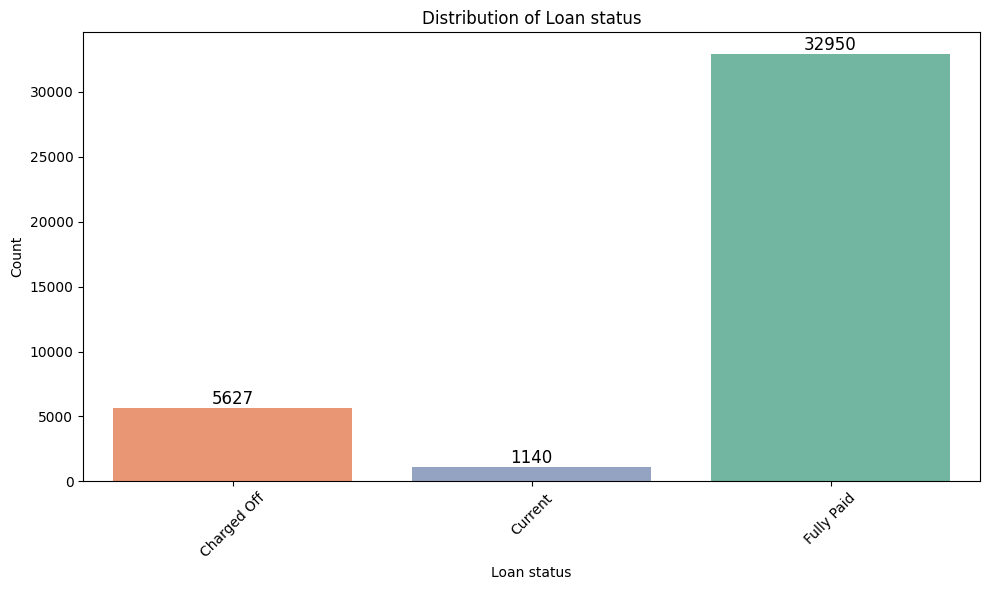

In [32]:
visualize_countplot_minimal(loan_clean_df, 'loan_status')

Considering Data for Risk Assessment:

> To identify potentially risky loan applicants, we'll focus on loans that have reached a definitive outcome: either fully paid or charged off. Therefore, we'll exclude loans that are still in the "current" status from our analysis.

In [ ]:
# Creating duplicate data
loan_df = loan_clean_df[~(loan_clean_df['loan_status'] == 'Current')].copy(deep=True)


In [ ]:
# Print summary statistics of the newly created of DF
print("Summary Statistics:")
display(loan_df.describe())
loan_df[['out_prncp', 'out_prncp_inv']].value_counts()

out_prncp  out_prncp_inv
0.00       0.00             38577
Name: count, dtype: int64

As we have dropped rows `loan_status` as Current, `out_prncp`, `out_prncp_inv` columns are expected to have invalid values as per definition.
As now this values become invalid we will drop this columns.

In [38]:
loan_df = loan_df.drop(columns=['out_prncp', 'out_prncp_inv'])

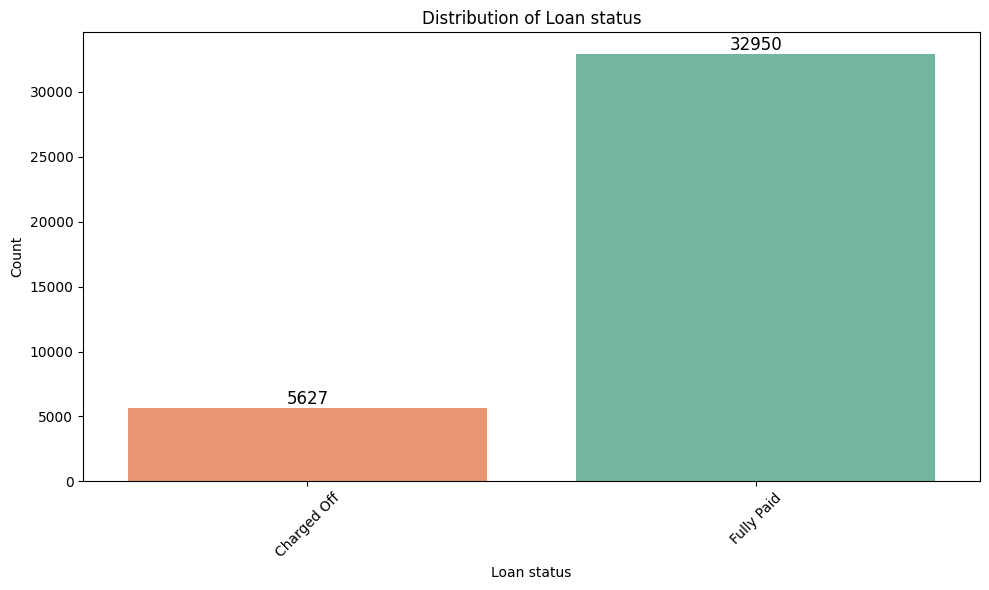

In [39]:
visualize_countplot_minimal(loan_df, 'loan_status')

In [40]:
# Identifies numeric, categorical and datetime columns in a DataFrame.
numeric_cols = loan_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = loan_df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = loan_df.select_dtypes(include=['datetime']).columns.tolist()

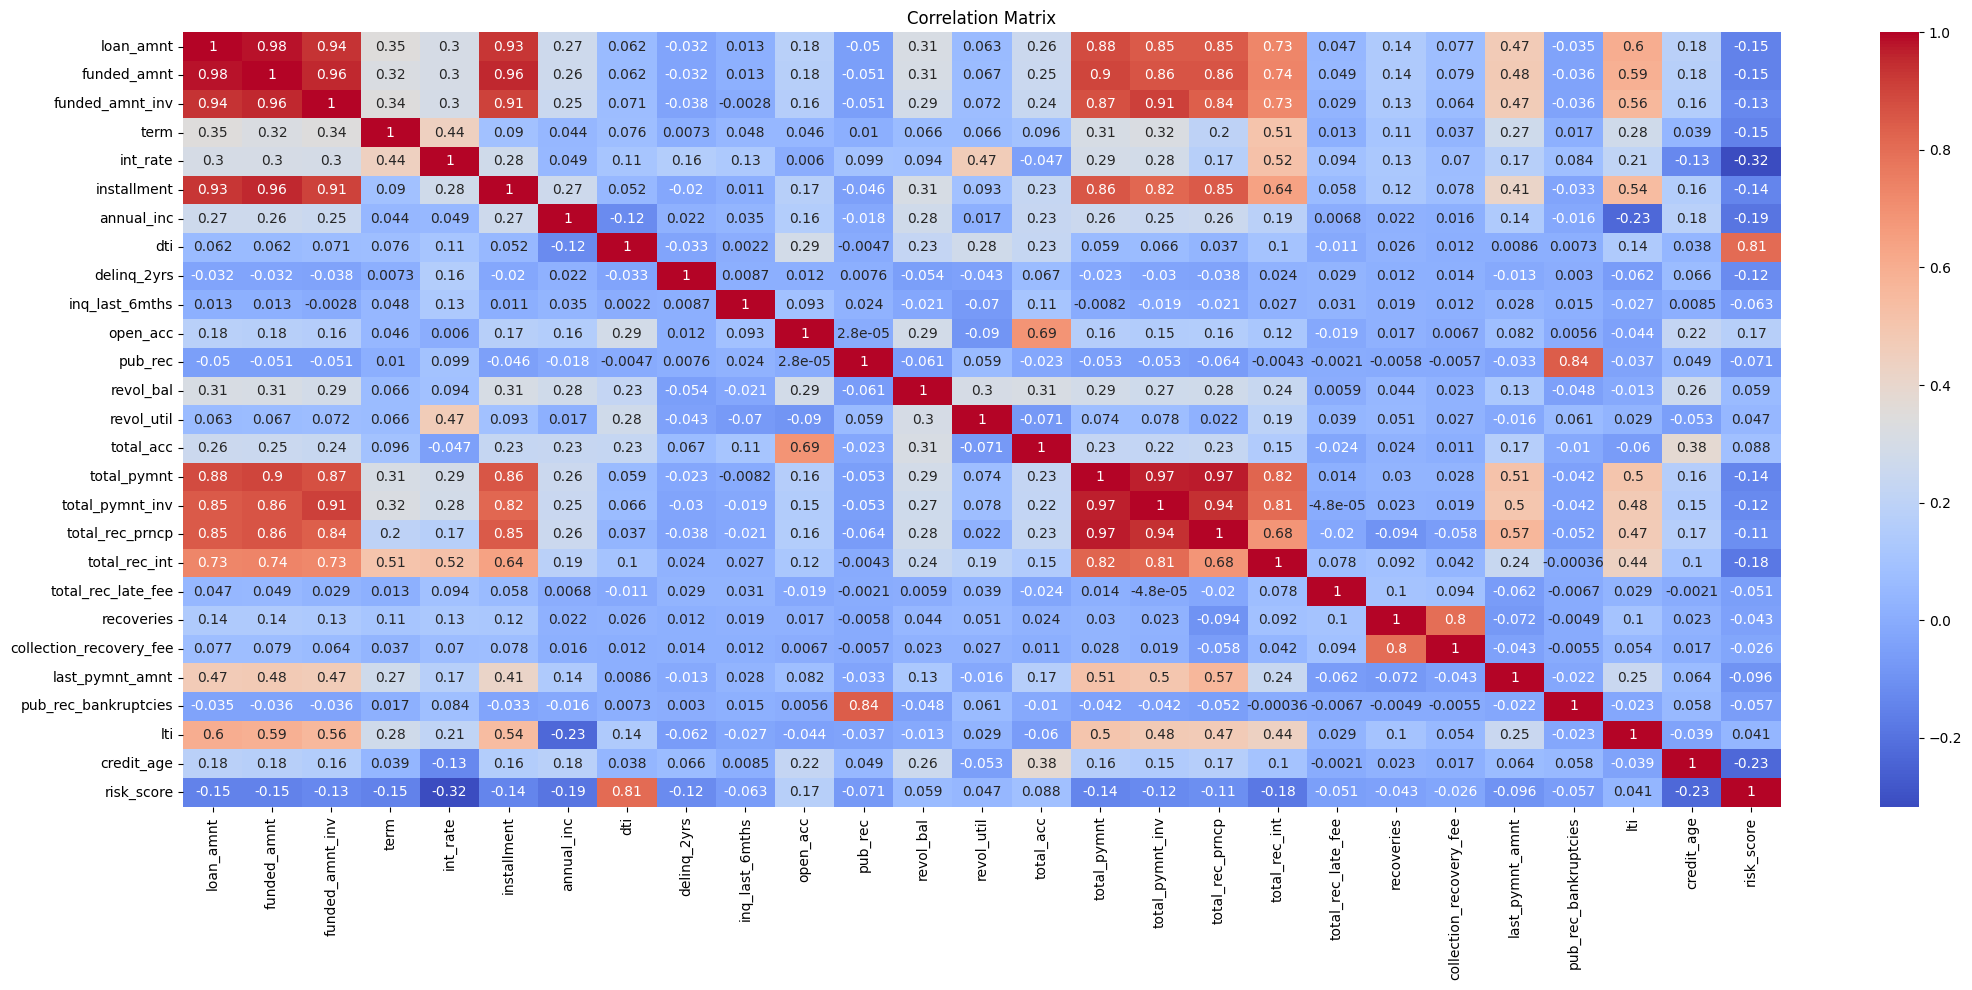

In [41]:
# Correlation matrix for numeric features
plt.figure(figsize=(22, 10))
corr = loan_df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### 🎯Key Observations:
- Strong Positive Correlations:
  - `loan_amnt` and `funded_amnt`, `funded_amnt_inv`, `installment`: These variables are highly correlated, indicating that as the loan amount increases, so do the funded amount, funded amount invested, and installment payments. 
  - , `total_paymnt`, `total_pymnt_inv`, `total_rec_prncp`, `total_rec_int`: These variables are also strongly correlated, suggesting that as the total payment increases, so do the total principal and interest payments received.

- Moderate Positive Correlations:
  - `annual_inc` and `installment`: There's a moderate positive correlation, implying that individuals with higher annual incomes tend to have larger installment payments.

- Weak or No Correlations:
  - Several variables show weak or no correlation with each other, indicating that they are not strongly related.


In [42]:
# Set a threshold for high correlation (adjust as needed)
threshold = 0.8

# Find pairs of features with correlation greater than the threshold
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            col_name = corr.columns[i]
            correlated_features.add(col_name)

print("Drop the correlated features", correlated_features)

loan_df = loan_df.drop(columns=filter(lambda col: col in loan_df.columns, correlated_features))
numeric_cols = loan_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
loan_df.shape

Drop the correlated features {'funded_amnt', 'risk_score', 'pub_rec_bankruptcies', 'total_rec_int', 'installment', 'total_pymnt_inv', 'total_rec_prncp', 'total_pymnt', 'funded_amnt_inv'}


(38577, 34)

### 🔢Univariate analysis Numerical data

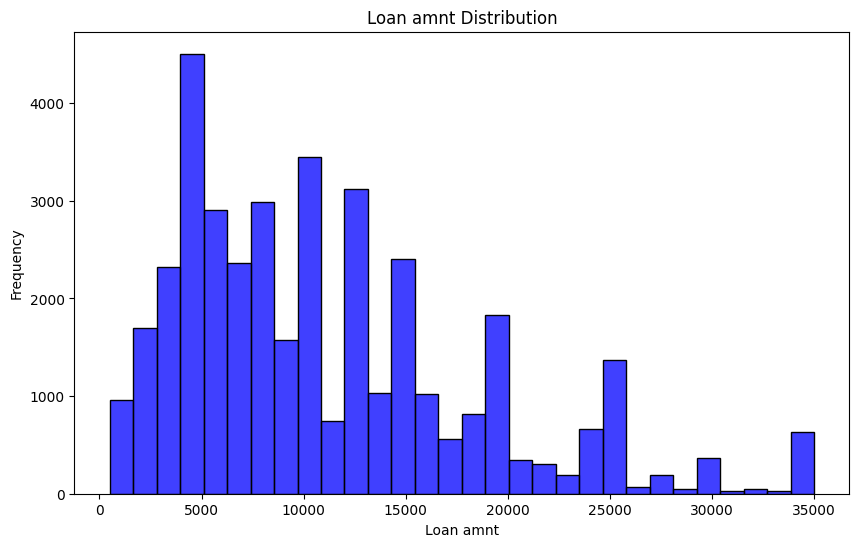

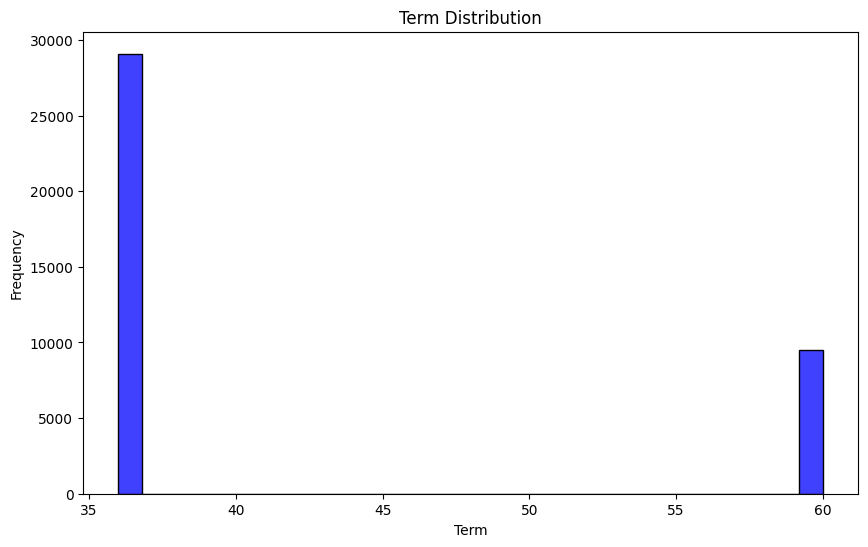

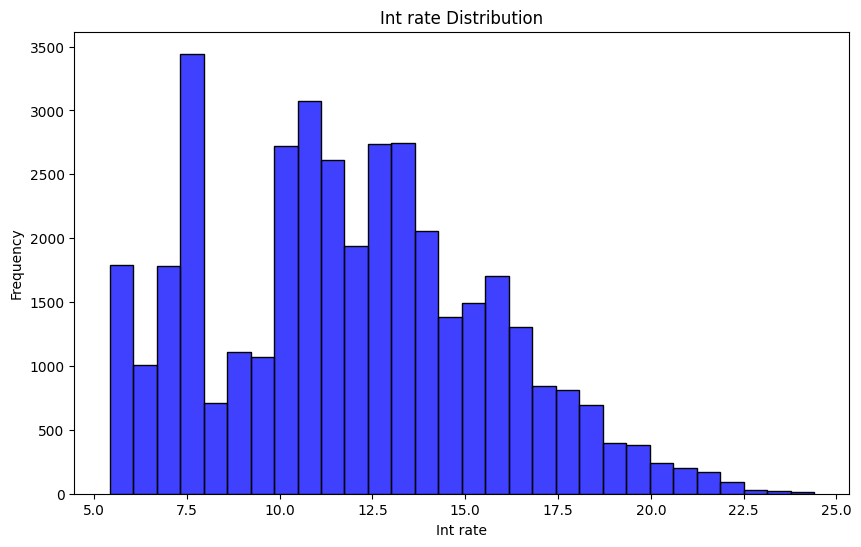

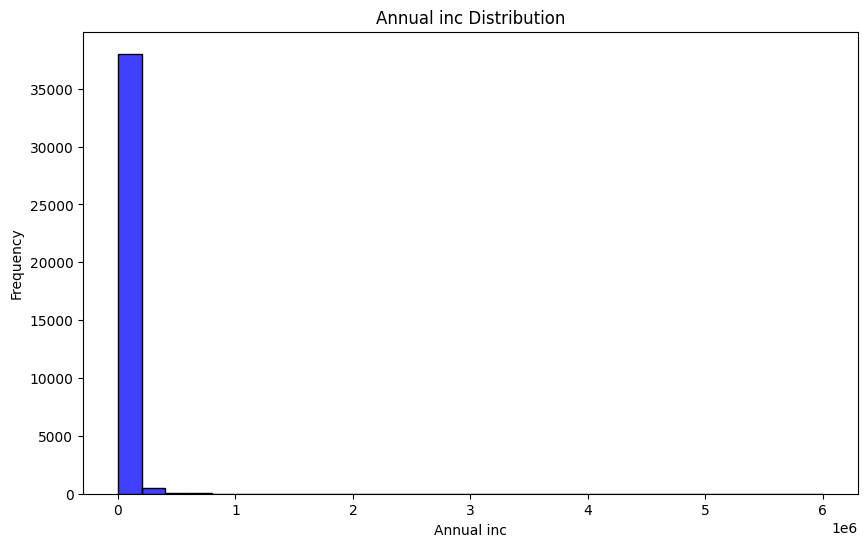

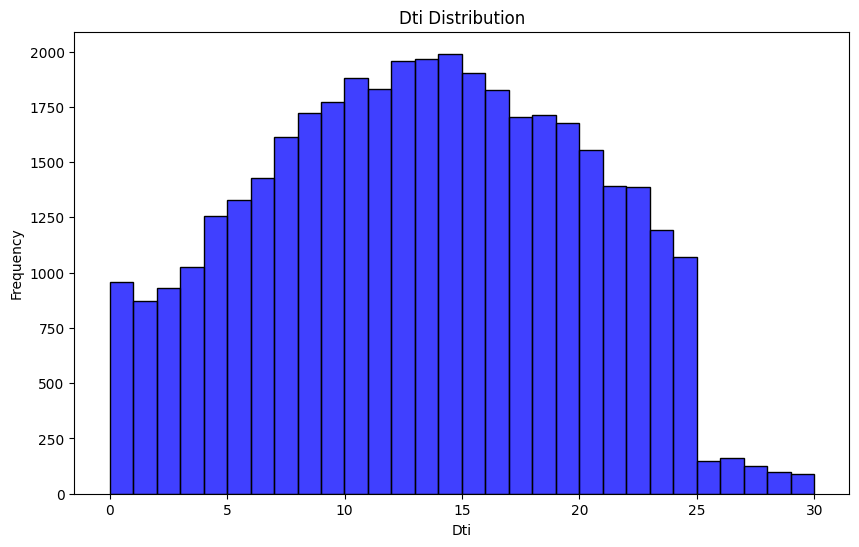

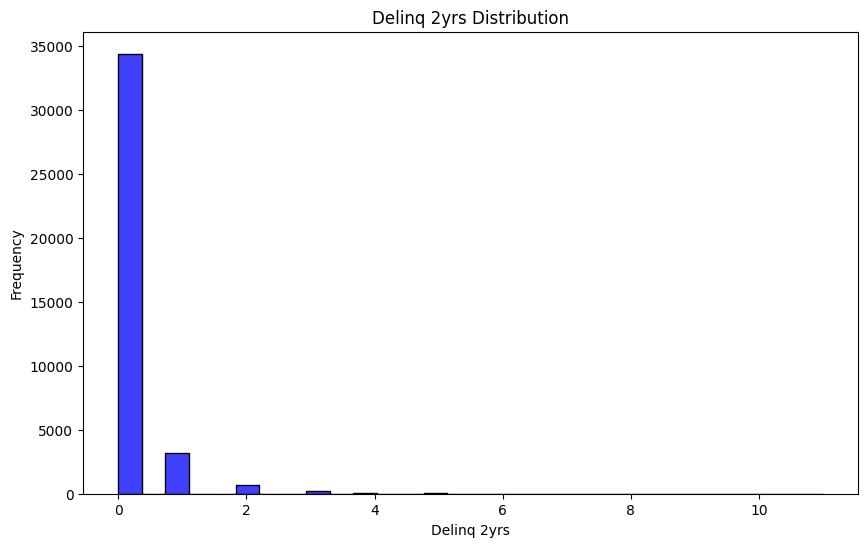

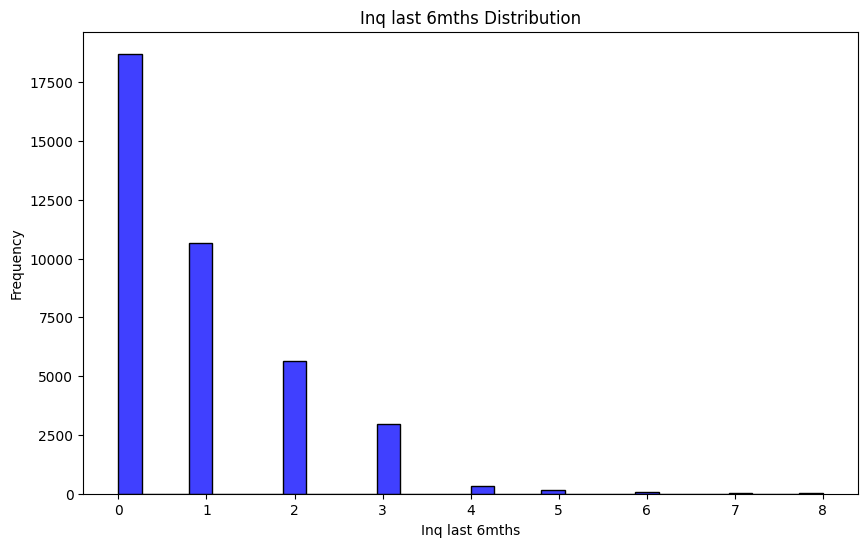

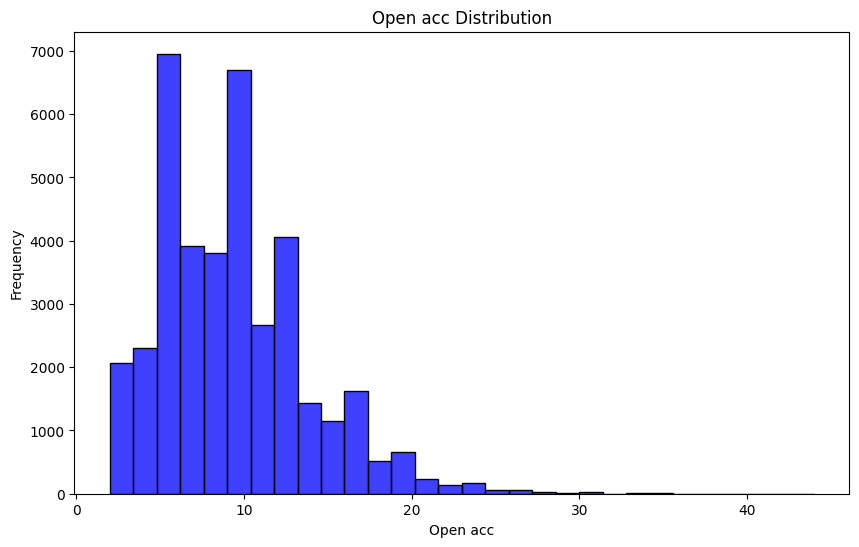

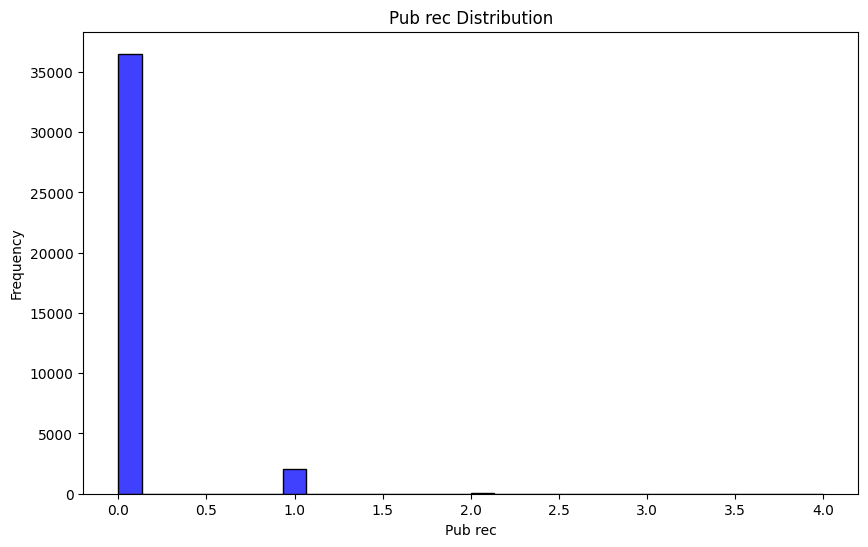

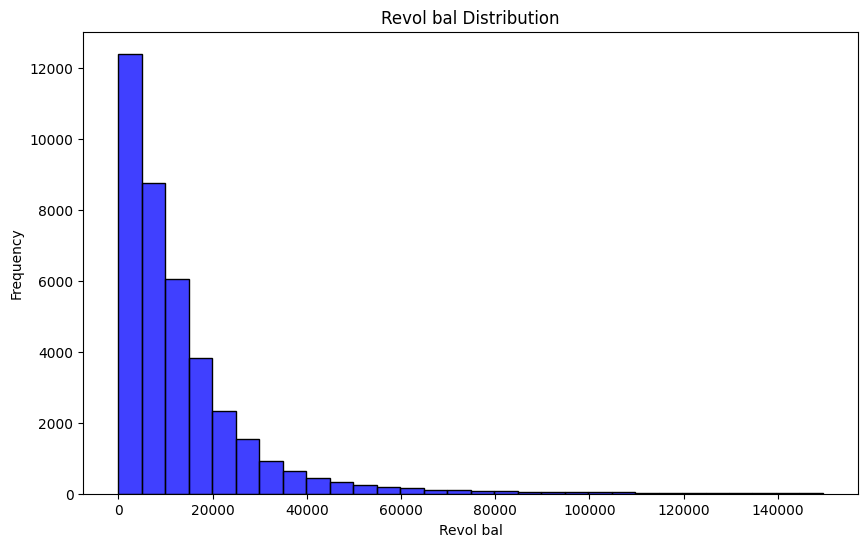

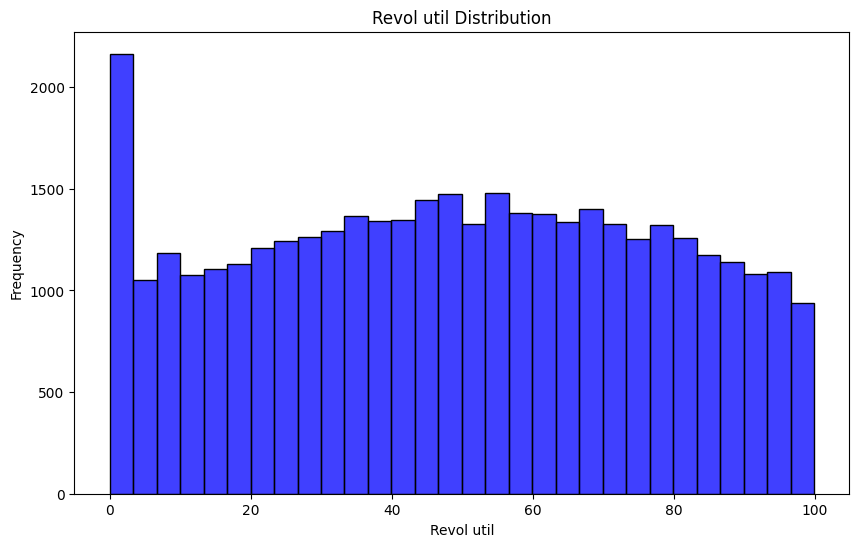

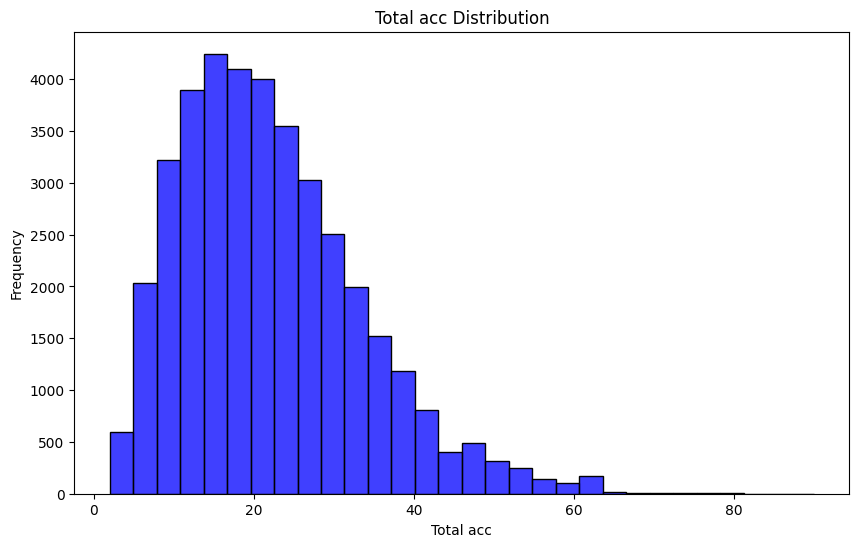

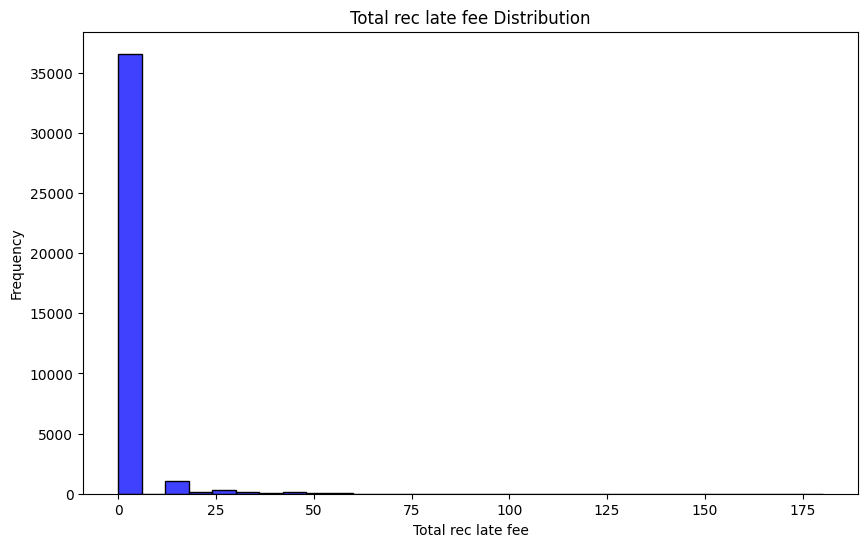

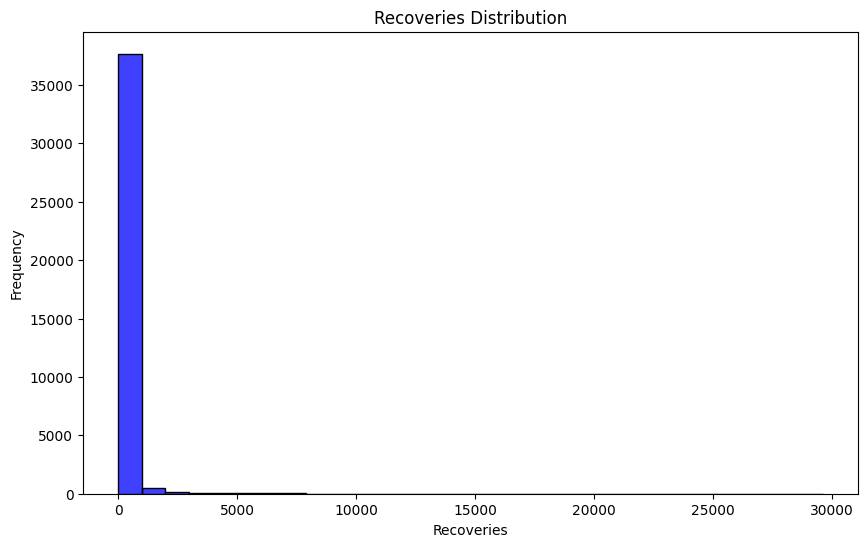

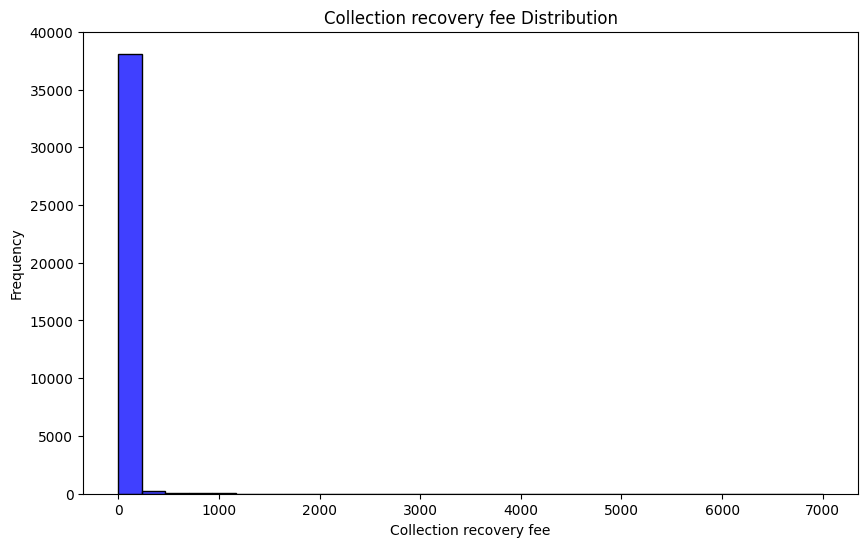

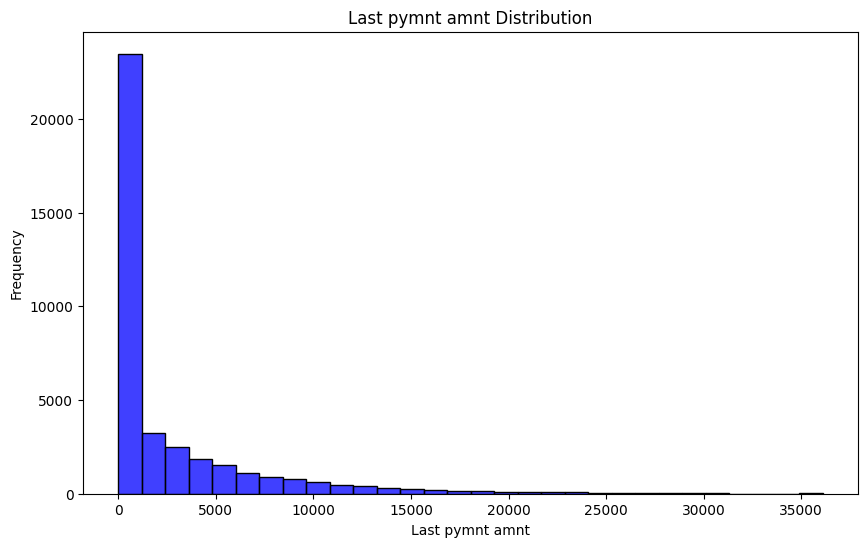

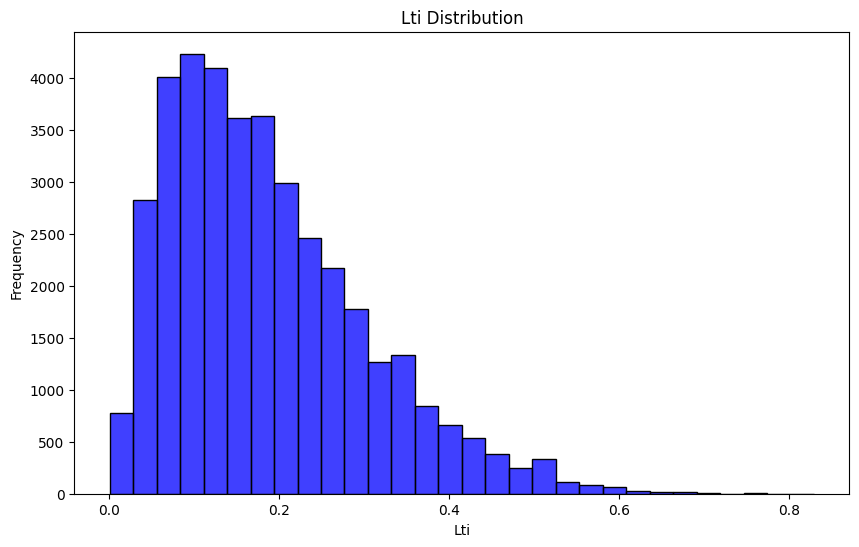

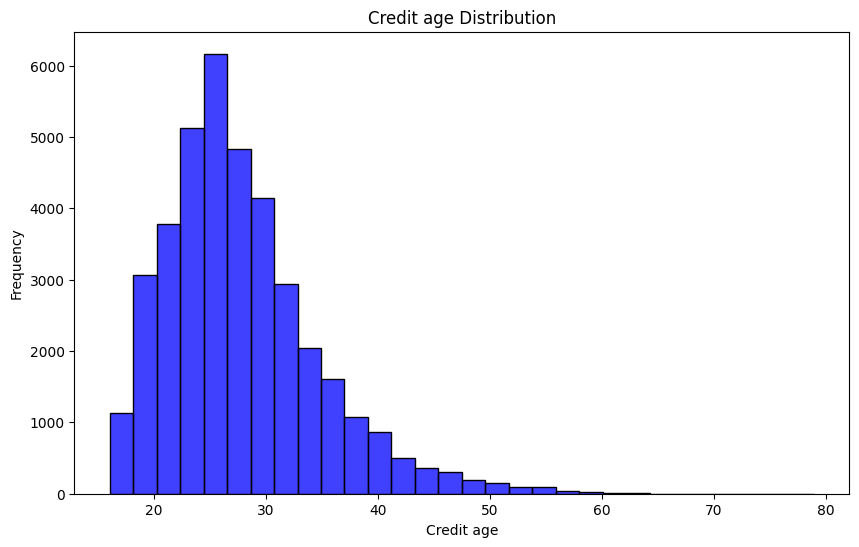

In [ ]:
for num_col in numeric_cols:
    visualize_histplot_minimal(loan_df, num_col)

In [ ]:

# Check relationships (Example: Loan amount vs Interest rate)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=loan_clean_df, x='loan_amnt', y='int_rate', hue='grade', palette='Set2')
plt.title('Loan Amount vs Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.legend(title='Grade')
plt.show()


# Visualize distributions (Example: Loan amount)
plt.figure(figsize=(10, 6))
sns.histplot(loan_clean_df['loan_amnt'], kde=True, bins=30, color='blue')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()
# Check relationships (Example: Loan amount vs Interest rate)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=loan_clean_df, x='loan_amnt', y='int_rate', hue='grade', palette='Set2')
plt.title('Loan Amount vs Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.legend(title='Grade')
plt.show()
# Create separate DataFrames for Fully Paid and Charged Off loans
fully_paid_df = loan_clean_df[loan_clean_df['loan_status'] == 'Fully Paid'].groupby('grade')['grade'].count().reset_index(name='count')
charged_off_df = loan_clean_df[loan_clean_df['loan_status'] == 'Charged Off'].groupby('grade')['grade'].count().reset_index(name='count')
current_df = loan_clean_df[loan_clean_df['loan_status'] == 'Current'].groupby('grade')['grade'].count().reset_index(name='count')


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='grade', y='count', data=fully_paid_df, label='Fully Paid', ax=ax)
sns.barplot(x='grade', y='count', data=charged_off_df, label='Charged Off', color='orange', ax=ax)
sns.barplot(x='grade', y='count', data=current_df, label='Current', color='purple', ax=ax)
ax.set_title('Loan Status by Grade')
ax.set_xlabel('Grade')
ax.set_ylabel('Count')
ax.legend()
plt.show()
# Check rows with missing critical values
important_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'loan_status']
missing_critical = loan_clean_df[important_cols].isnull().sum()
print("\nMissing Values in Critical Columns:")
print(missing_critical)
# Boxplot: Annual Income by Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=loan_clean_df, x='loan_status', y='annual_inc', palette='Set2')
plt.title('Annual Income by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.show()
# Default Rate by Loan Purpose
purpose_default = loan_clean_df.groupby('purpose')['loan_status'].apply(lambda x: (x == 'Charged Off').mean())
purpose_default = purpose_default.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=purpose_default.index, y=purpose_default.values, palette='magma')
plt.title('Default Rate by Loan Purpose')
plt.xticks(rotation=45)
plt.ylabel('Default Rate')
plt.show()
# Encode Target Variable (e.g., 1 for default, 0 otherwise)
loan_clean_df['is_default'] = loan_clean_df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# Correlation with Target Variable
corr_with_default = loan_clean_df[numeric_cols+['is_default']].corr()['is_default'].sort_values(ascending=False)
print("\nTop Correlations with Default Status:")
print(corr_with_default.head(10))

In [ ]:
visualize_countplot_minimal(loan_clean_df, categorical_col)